# Import libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)

# for audio
from IPython.display import Audio
import librosa

# For visualization
import matplotlib.pyplot as plt
#%matplotlib inline

# For drive access
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load training data csv file

In [2]:
df = pd.read_csv('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/train_val.csv')

df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train
2,eaywag1,eaywag1/XC722533.ogg,blank,eaywag1/XC722533.npy,good,58.104000,RU,EUROPE,train
3,eaywag1,eaywag1/XC673617.ogg,call,eaywag1/XC673617.npy,poor,18.756000,GB,EUROPE,train
4,eaywag1,eaywag1/XC675935.ogg,call,eaywag1/XC675935.npy,good,16.666000,RU,EUROPE,train


In [3]:
train_df = df[df['data'] == 'train']
train_df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train
2,eaywag1,eaywag1/XC722533.ogg,blank,eaywag1/XC722533.npy,good,58.104000,RU,EUROPE,train
3,eaywag1,eaywag1/XC673617.ogg,call,eaywag1/XC673617.npy,poor,18.756000,GB,EUROPE,train
4,eaywag1,eaywag1/XC675935.ogg,call,eaywag1/XC675935.npy,good,16.666000,RU,EUROPE,train


# Define augmentation functions

In [4]:
sr=16000

In [5]:
# NOISE
def noise(data):
  noise_amp = np.random.normal(loc=0.0, scale=0.05)*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

# STRETCH
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(y=data, rate=rate)

# SHIFT
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

# PITCH
def pitch(data, sampling_rate=sr, pitch_factor=0.7):
  return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# Load one example and visualize the results of augmentation

In [6]:
example = np.load('/content/drive/MyDrive/207/207-Project/data/train/librosa_loaded/' + train_df['filename_npy'].iloc[0])
example

array([ 8.50955257e-06,  1.51871936e-05,  2.57813517e-05, ...,
       -1.34145375e-06, -7.96734821e-06, -1.04890205e-05], dtype=float32)

In [7]:
Audio(example, rate=sr)

In [8]:
noisy = noise(example)
shifted = shift(example)
pitched = pitch(example)
stretched = stretch(example)

In [9]:
display('original', Audio(example, rate=sr))
display('noisy', Audio(noisy, rate=sr))
display('shifted', Audio(shifted, rate=sr))
display('pitched', Audio(pitched, rate=sr))
display('stretched', Audio(stretched, rate=sr))

Output hidden; open in https://colab.research.google.com to view.

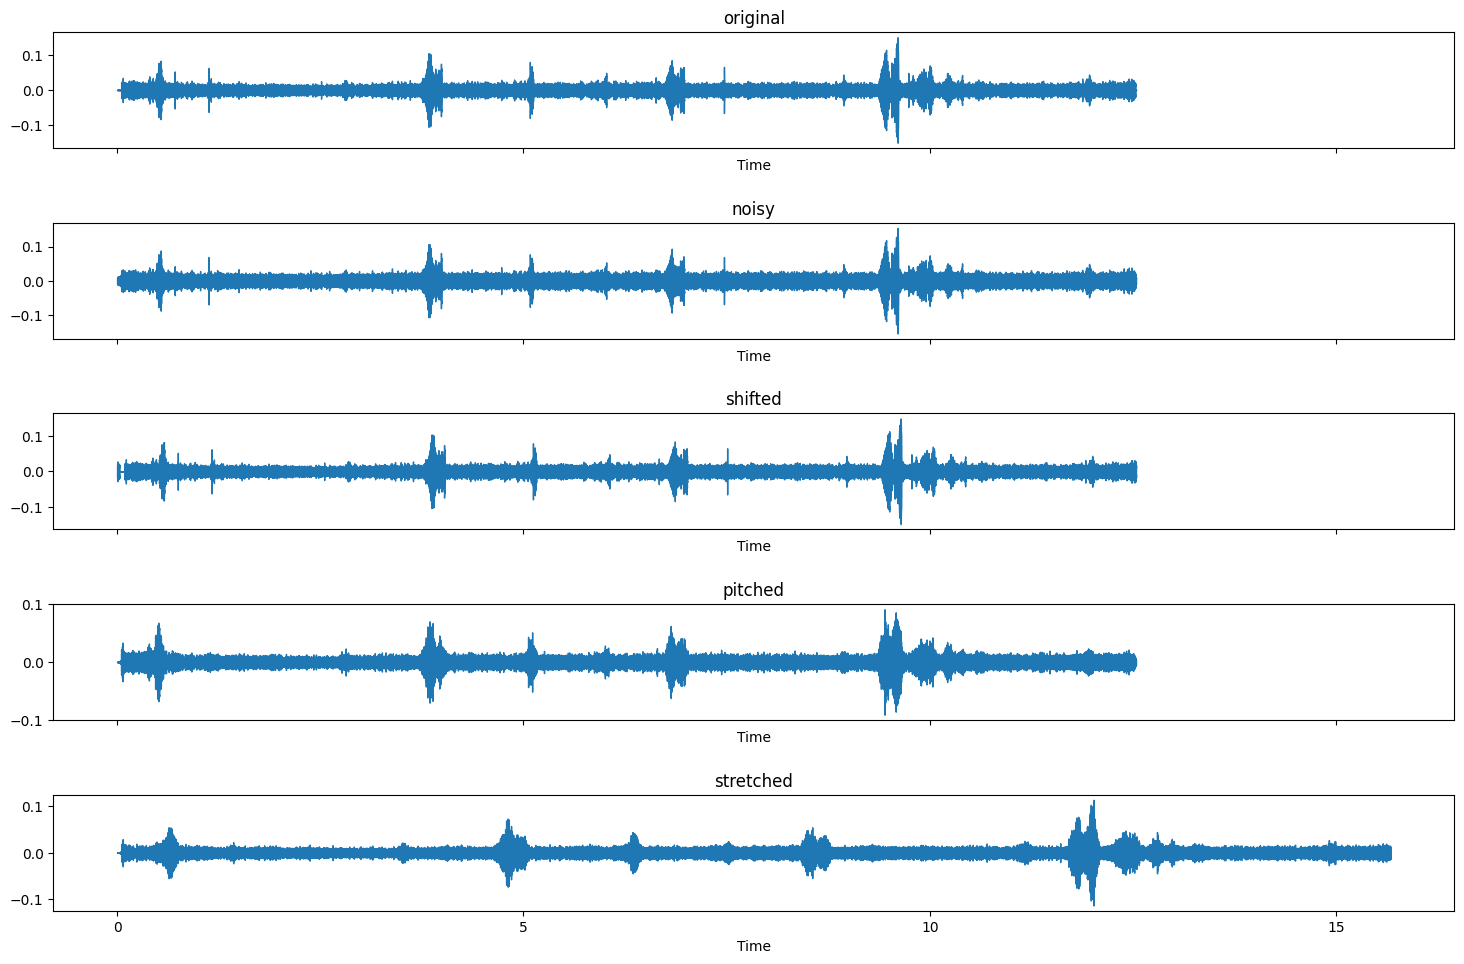

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,10), sharex=True)

librosa.display.waveshow(y=example, sr=sr, ax=axes[0])
axes[0].set_title('original')

librosa.display.waveshow(y=noisy, sr=sr, ax=axes[1])
axes[1].set_title('noisy')

librosa.display.waveshow(y=shifted, sr=sr, ax=axes[2])
axes[2].set_title('shifted')

librosa.display.waveshow(y=pitched, sr=sr, ax=axes[3])
axes[3].set_title('pitched')

librosa.display.waveshow(y=stretched, sr=sr, ax=axes[4])
axes[4].set_title('stretched')

fig.tight_layout(pad=2.0)

plt.show()

# Define a function to apply augmentation to audio files & try it out

In [30]:
def augment(audio_array: np.ndarray) -> np.ndarray:
  choice = np.random.choice(['noise','stretch','shift','pitch'])
  if choice == 'noise':
    amount = np.random.normal(loc=0.0, scale=0.05)
    noise_amp = amount*np.amax(audio_array)
    audio_array = audio_array + noise_amp*np.random.normal(size=audio_array.shape[0])
    print('noise', amount)
  elif choice == 'stretch':
    audio_array = librosa.effects.time_stretch(y=audio_array, rate=np.random.uniform(low=0, high=1))
    print('stretch')
  elif choice == 'shift':
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    audio_array = np.roll(audio_array, shift_range)
    print('shift')
  elif choice == 'pitch':
    audio_array = librosa.effects.pitch_shift(y=audio_array, sr=sr, n_steps=np.random.uniform(low=0, high=1))
    print('pitch')
  else:
    audio_array = audio_array

  return audio_array

In [16]:
def load_audios(
    dataframe: pd.DataFrame
    ) -> list[np.ndarray]:

  audios = []

  for filename in dataframe['filename_npy']:
    audio = np.load('/content/drive/MyDrive/207/207-Project/data/train/librosa_loaded/' + filename)
    audios.append(audio)

  assert len(audios) == len(dataframe)

  return audios

In [17]:
subset = train_df.head(10)
subset

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train
2,eaywag1,eaywag1/XC722533.ogg,blank,eaywag1/XC722533.npy,good,58.104000,RU,EUROPE,train
3,eaywag1,eaywag1/XC673617.ogg,call,eaywag1/XC673617.npy,poor,18.756000,GB,EUROPE,train
4,eaywag1,eaywag1/XC675935.ogg,call,eaywag1/XC675935.npy,good,16.666000,RU,EUROPE,train
5,eaywag1,eaywag1/XC687217.ogg,call,eaywag1/XC687217.npy,good,47.177000,IE,EUROPE,train
6,eaywag1,eaywag1/XC695502.ogg,blank,eaywag1/XC695502.npy,good,15.621219,IT,EUROPE,train
7,eaywag1,eaywag1/XC266145.ogg,call,eaywag1/XC266145.npy,good,64.261219,NO,EUROPE,train
8,eaywag1,eaywag1/XC540595.ogg,call,eaywag1/XC540595.npy,good,15.480000,PT,EUROPE,train
9,eaywag1,eaywag1/XC648037.ogg,song,eaywag1/XC648037.npy,good,21.864500,PL,EUROPE,train


In [18]:
audios = load_audios(subset)
audios

[array([ 8.50955257e-06,  1.51871936e-05,  2.57813517e-05, ...,
        -1.34145375e-06, -7.96734821e-06, -1.04890205e-05], dtype=float32),
 array([-4.2310858e-06, -1.0121811e-05,  1.5354042e-05, ...,
        -1.2033241e-04, -2.5929388e-04, -4.3232553e-04], dtype=float32),
 array([-6.6661401e-06, -2.2037202e-05, -6.4746164e-06, ...,
         7.7251980e-06,  3.7547099e-05, -2.0133290e-05], dtype=float32),
 array([ 6.5648255e-06,  4.3115451e-06,  8.8462239e-06, ...,
        -5.4487269e-03, -3.7538039e-04,  1.5887603e-02], dtype=float32),
 array([-2.9578205e-06,  5.4683978e-06, -1.6285576e-05, ...,
        -1.1650051e-04, -3.7884188e-04, -4.9621076e-04], dtype=float32),
 array([ 1.2169941e-05, -1.4012912e-06, -9.0311805e-06, ...,
        -1.6832933e-02, -1.4799705e-02, -4.7362708e-02], dtype=float32),
 array([-1.0849131e-05, -9.5132382e-06, -1.0482097e-05, ...,
        -3.9131923e-05, -3.4946555e-05, -1.1528780e-05], dtype=float32),
 array([ 8.5134889e-07, -2.1818851e-06,  1.8039751e-05, 

In [31]:
augmented = []
for each in audios:
  augmented.append(augment(each))

noise 0.05418550202971437
stretch
shift
shift
stretch
shift
noise -0.0417920511863342
noise 0.033539247363166054
stretch
pitch


In [32]:
augmented = []
for each in audios:
  augmented.append(augment(each))

stretch
noise 0.021760858981560653
shift
pitch
shift
pitch
shift
stretch
stretch
noise -0.1379301377997938
